In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import os
import mplhep as hep

In [104]:
# This code consists of 4 parts 
# Part (1) where it plots a QCD vs signal plot for all rootfiles
# Part (2) where it plots the effect of the systematics for 1 rootfile
# Part (3) where it combines both and makes QCD vs signal and systematics plots for all rootfiles 
# Part (4) where multiple 

In [1]:
mass = '125'
f = uproot.open("../cards-SUEP-m{}-darkPhoHad/shapes-catSig2018.root".format(mass))

list_keys = []
for key in f.keys(): 
    key = key.replace(";1", "")
    list_keys.append(key)

print(list_keys) #Note that list_keys is the same for all root datafiles, so we can reuse this for the rest of the analysis


NameError: name 'uproot' is not defined

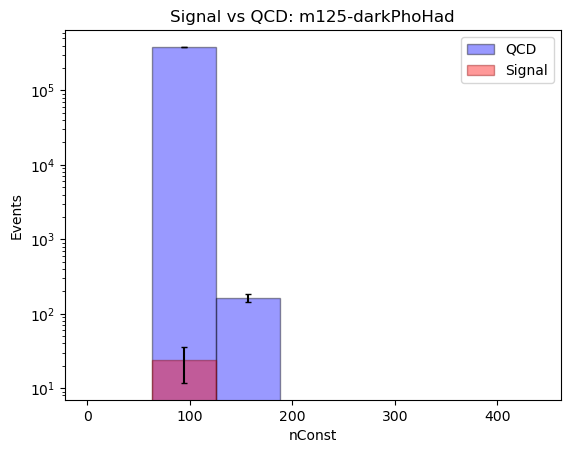

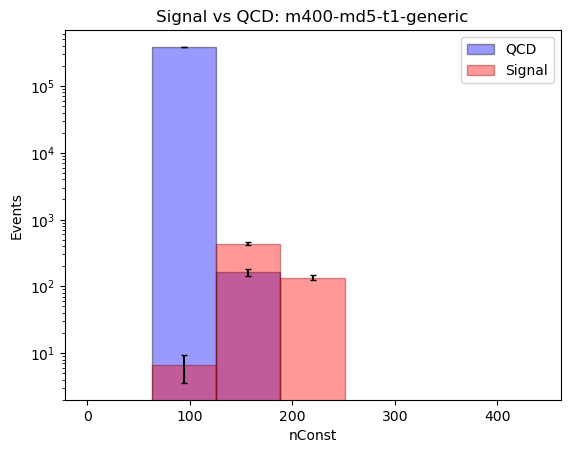

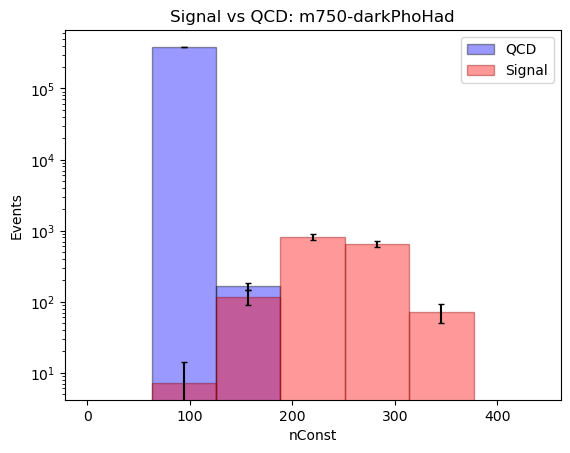

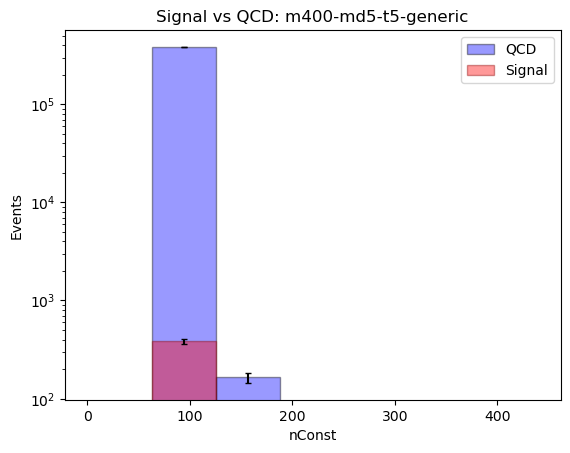

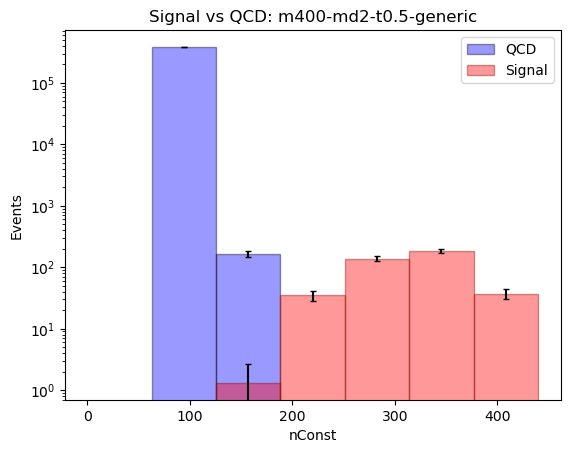

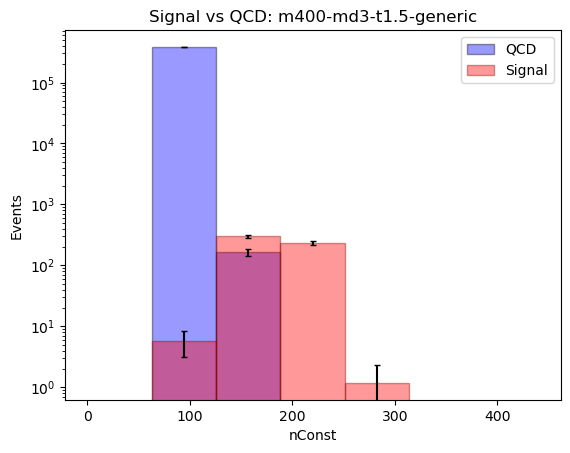

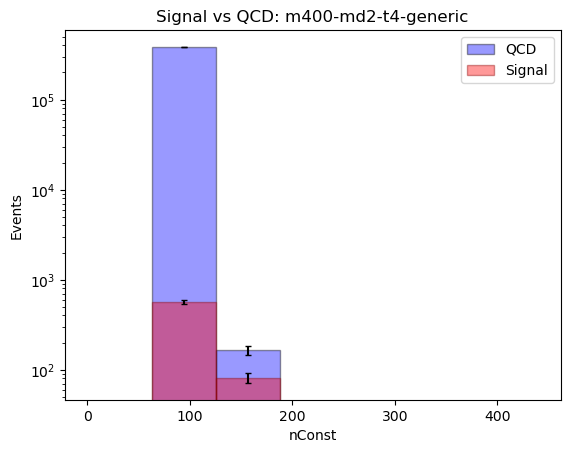

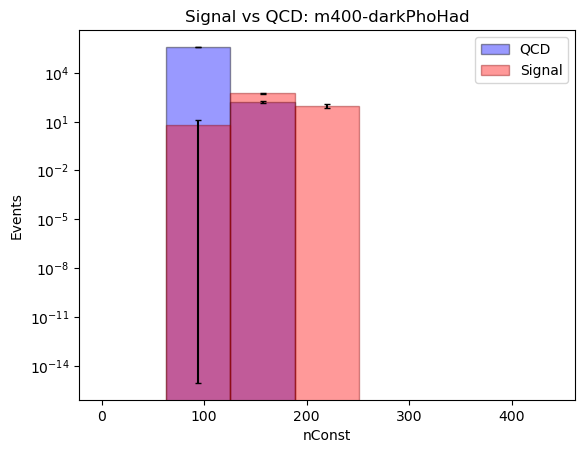

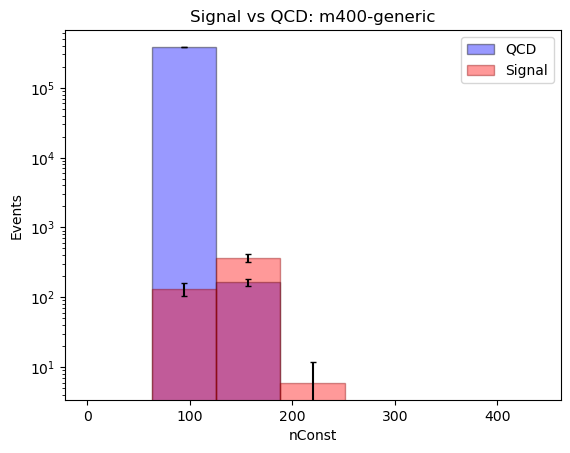

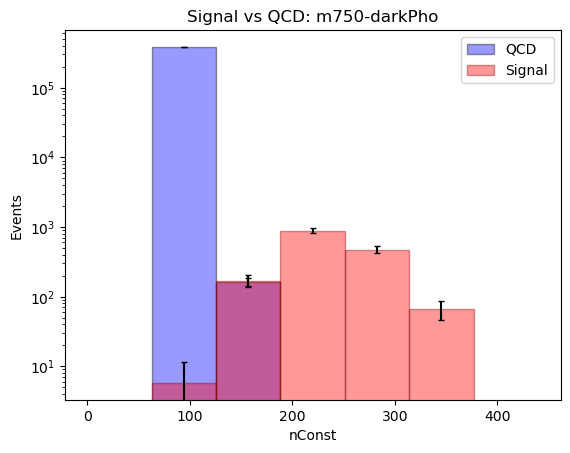

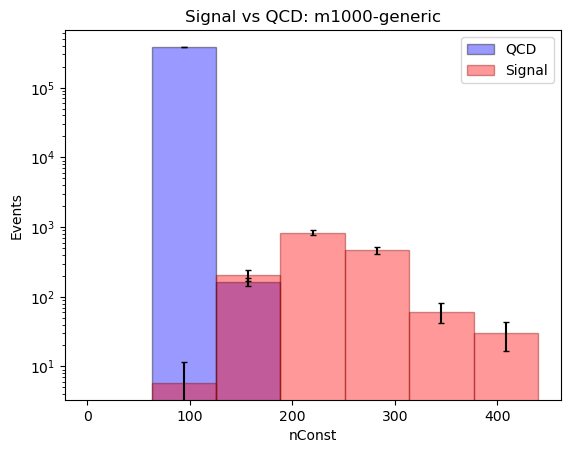

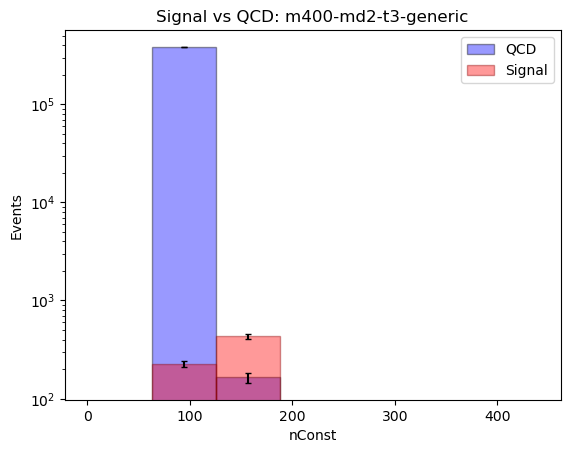

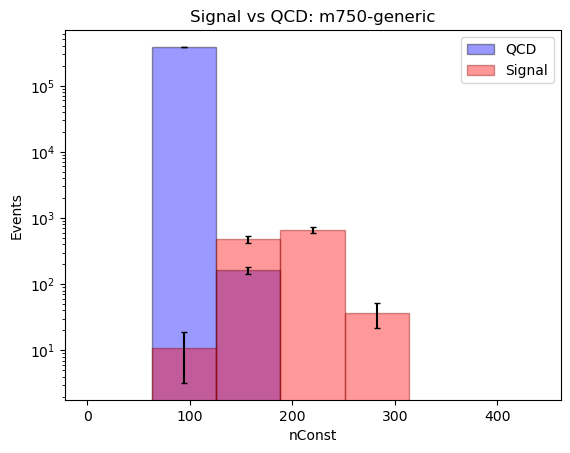

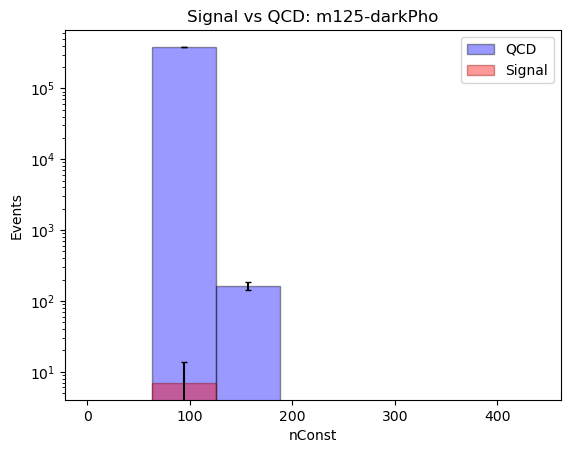

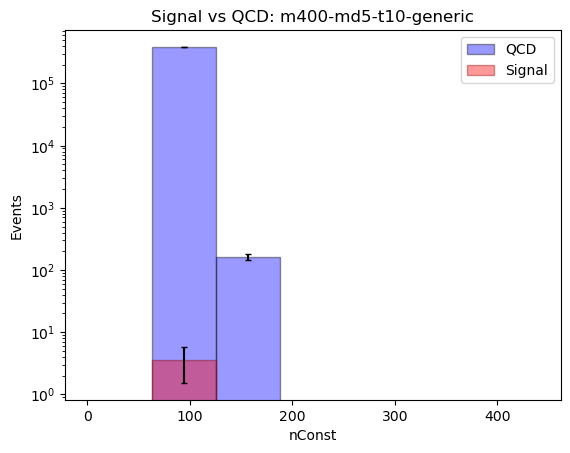

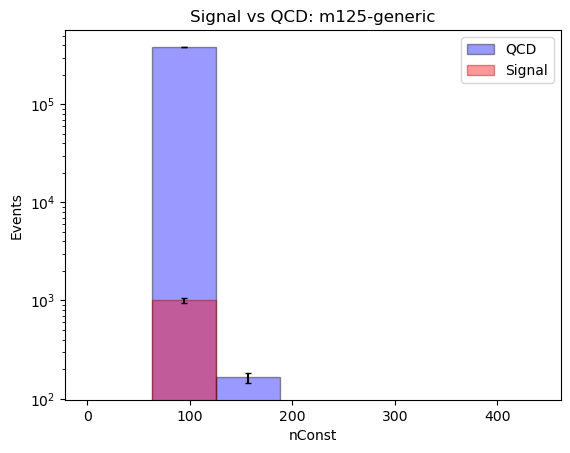

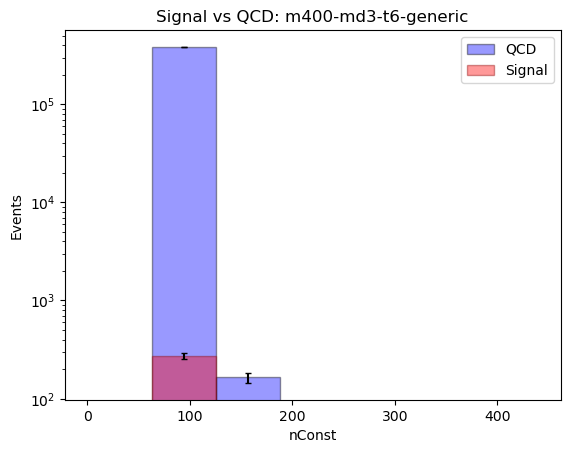

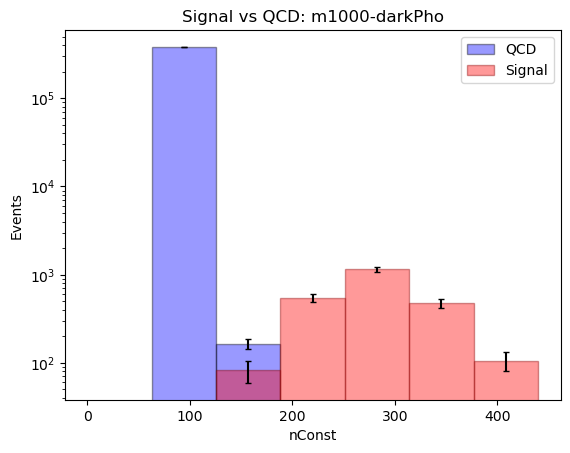

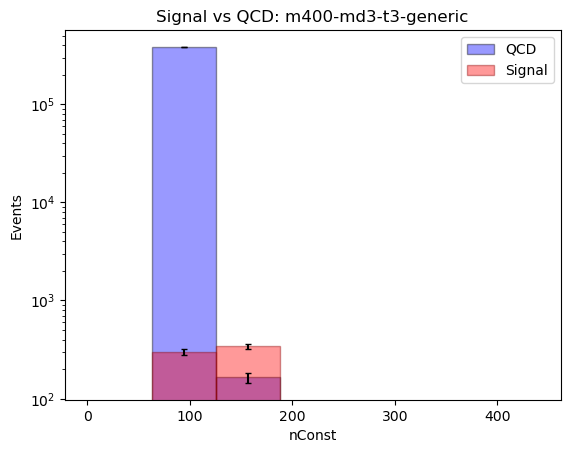

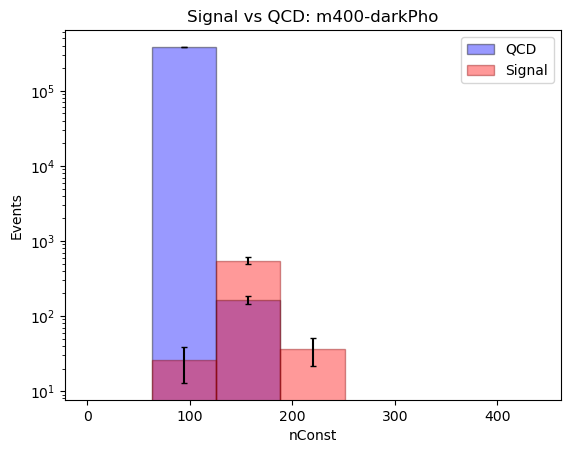

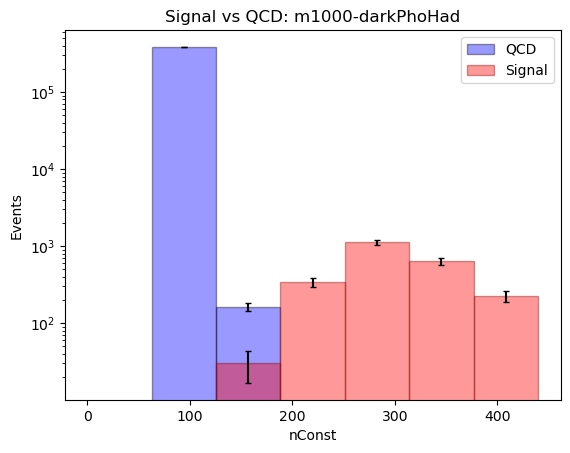

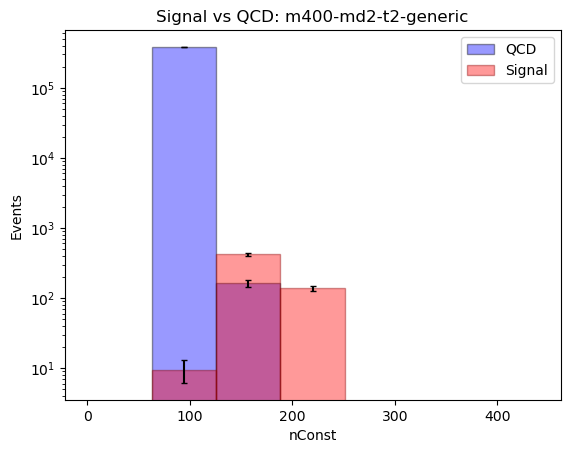

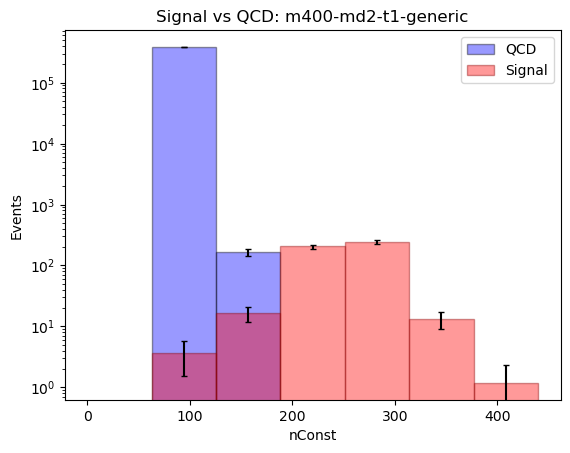

In [106]:
#PART 1

datafiles = {} #Dictionary with name of datafile and the rootfile
systs = ['JES_2018','JER_2018','PU_2018','trigSF_2018','PS_ISR_2018','PS_FSR_2018','trk_kill_2018']

for folder in os.listdir('../'):
    
    if folder[0:5] == 'cards': #Check if it is the right folder
        file_name = folder[11:] #This gives an easily readable name for the file like m125-darkPhoHad
        datafiles[file_name]= uproot.open("../cards-SUEP-{}/shapes-catSig2018.root".format(file_name))

for name,f in datafiles.items(): #Iterate the analysis of above for all datafiles
    
    #Adjust keys
    for key in f.keys(): 
        key = key.replace(";1", "")
    
    #Plot QCD vs signal
    exp = f["expected"].to_boost()
    sig = f["Signal"].to_boost()

    plt.bar(*exp.axes.centers, exp.values(), width=exp.axes.widths[0], yerr=exp.variances()**0.5,color= 'blue',edgecolor='black', alpha = 0.4,label='QCD',capsize =2)
    plt.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5, color= 'red',edgecolor='darkred', alpha =0.4, label = 'Signal',capsize =2)
    plt.title("Signal vs QCD: " + name )
    plt.ylabel("Events")
    plt.xlabel("nConst")
    plt.yscale('log')
    plt.legend()
    plt.show()

    
    
    
    
    


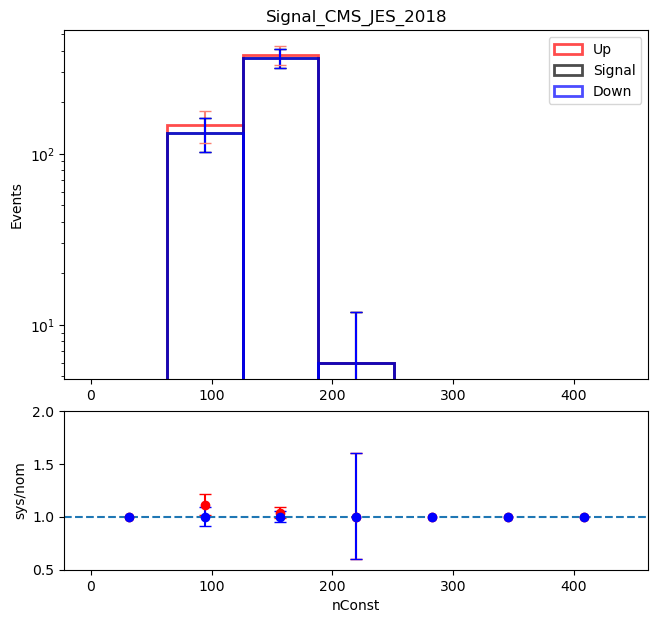

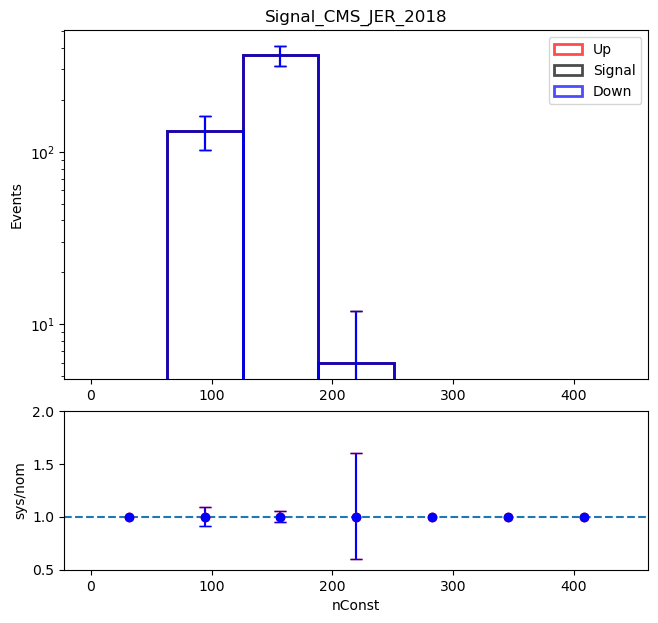

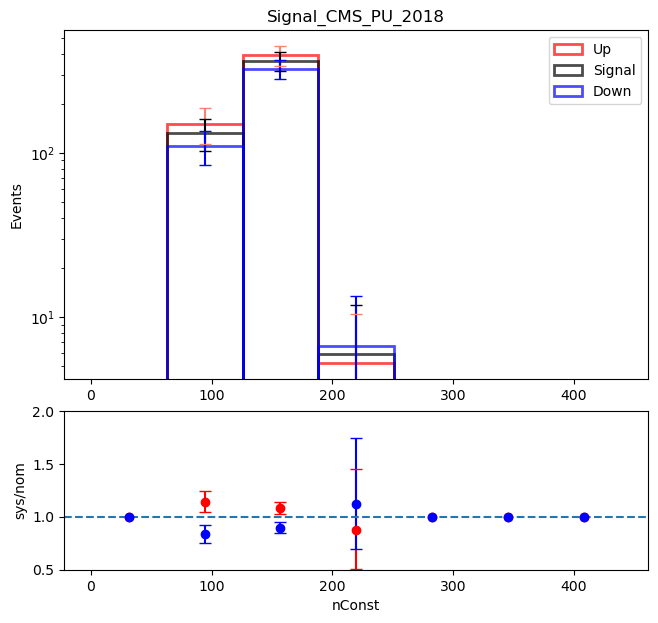

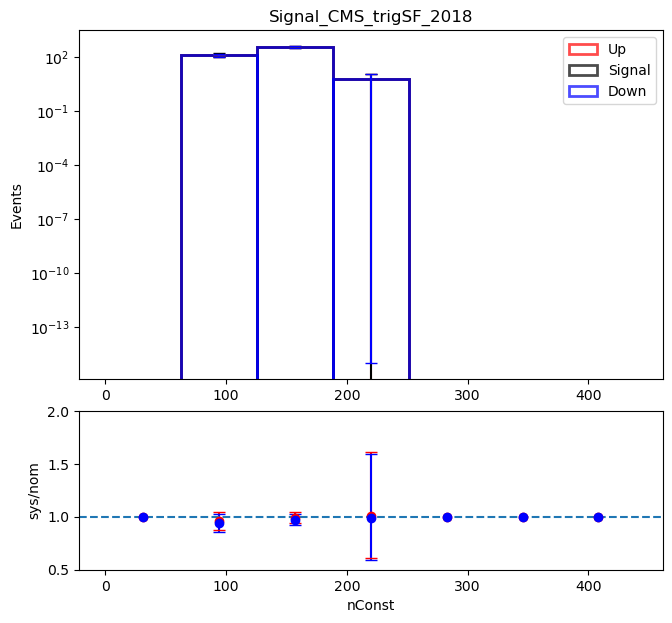

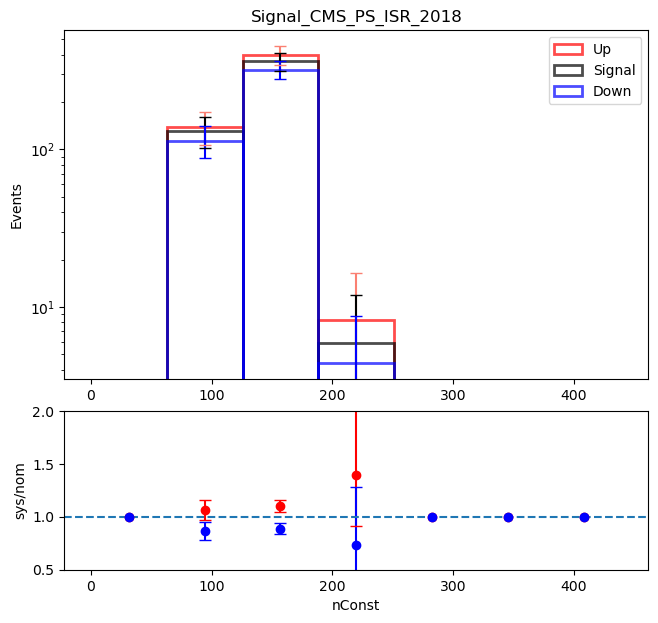

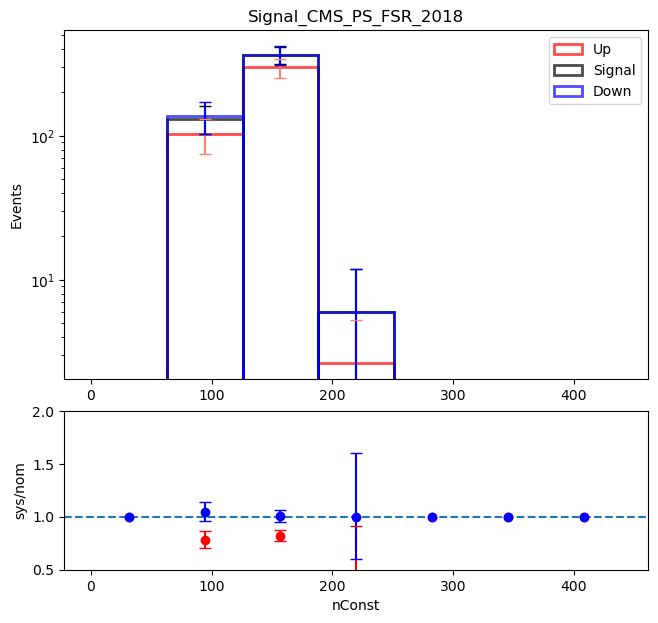

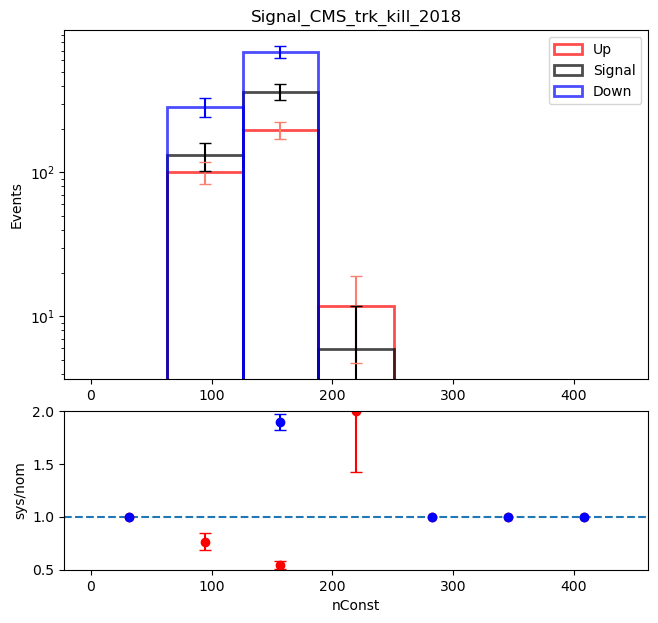

In [107]:
#PART 2
#This block of code makes ratio plots for a single datafile

systs = ['JES_2018','JER_2018','PU_2018','trigSF_2018','PS_ISR_2018','PS_FSR_2018','trk_kill_2018']

mass = '400'
f = uproot.open("../cards-SUEP-m{}-generic/shapes-catSig2018.root".format(mass))

for sys in systs:
    
    sig = f['Signal'].to_boost()
    
    if "Signal_CMS_"+sys+"Up" in list_keys:
        up = f["Signal_CMS_"+sys+"Up"].to_boost()
        down = f["Signal_CMS_"+sys+"Down"].to_boost()

    plt.figure(figsize=(8,10))
    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)
    
    # Plot histograms of systematics 
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)
    ax1.bar(*up.axes.centers, up.values(), width=up.axes.widths[0],yerr=up.variances()**0.5,fill=False,color= 'salmon',edgecolor='red',linewidth=2,alpha =0.7,label='Up',capsize=4,ecolor = 'salmon')
    ax1.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5,fill=False,linewidth=2,color= 'grey',edgecolor='black',alpha=0.7, label='Signal',capsize=4, ecolor='black')
    ax1.bar(*down.axes.centers, down.values(), width=down.axes.widths[0],yerr=down.variances()**0.5,color= 'lightblue',fill=False,edgecolor='blue',alpha=0.7,linewidth=2,label='Down',capsize=4,ecolor='blue')
    ax1.set_title("Signal_CMS_"+sys)
    ax1.set_ylabel("Events")
    ax1.set_yscale('log')
    ax1.legend()
    
    
    # Make ratio plot
    up_ratio = np.divide( up.values(), sig.values(), out=np.ones_like(up.values()), where=sig.values()!=0) #Overestimate
    down_ratio = np.divide( down.values(), sig.values(), out=np.ones_like(down.values()), where=sig.values()!=0) #Underestimate
    
    #Calculate errors in up_ratio and down_ratio
    up_err = hist.intervals.ratio_uncertainty(up.values(),sig.values()) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
    down_err = hist.intervals.ratio_uncertainty(down.values(),sig.values())
    
    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
    ups = ax2.errorbar(*sig.axes.centers, up_ratio,fmt='o', color='red', label = 'up',yerr= up_err,capsize=4)
    downs = ax2.errorbar(*sig.axes.centers, down_ratio,fmt='o', color='blue', label = 'down',yerr= down_err,capsize=4)
    ax2.axhline(1,ls='--')
    ax2.set_ylim([0.5,2.0])
    ax2.set_xlabel('nConst')
    ax2.set_ylabel('sys/nom')

    plt.show()
    


In [108]:
# PART 3

# This block of code loops through every datafile to make
# (1) a histogram showing the signal vs the expected QCD background
# and (2) plots for the effects of the different systematics
# All the plots are saved in a new directory 'plots' with subdirectories for every datafile

if not os.path.exists('plots'):
    !mkdir plots

datafiles = {} #This is a dictionary containing the names (key) and values of the datafiles
systs = ['JES_2018','JER_2018','PU_2018','trigSF_2018','PS_ISR_2018','PS_FSR_2018','trk_kill_2018']

for folder in os.listdir('../'):
    
    if folder[0:5] == 'cards': #Check if it is the correct folder
        file_name = folder[11:] #This gives an easily readable name for the file like m125-darkPhoHad
        datafiles[file_name]= uproot.open("../cards-SUEP-{}/shapes-catSig2018.root".format(file_name))

        
for name,f in datafiles.items(): # Do the analysis for every datafile
    
    print(name) #To get an idea of how long the code takes to execute
    
    #Adjust keys
    for key in f.keys(): 
        key = key.replace(";1", "")
    
    folder_name = 'plots/'+name # Make a folder for every datafile to save the plots
    if not os.path.exists(folder_name):
        !mkdir $folder_name
    
    
    #Make Signal VS QCD plots
    exp = f["expected"].to_boost()
    sig = f["Signal"].to_boost()

    plt.bar(*exp.axes.centers, exp.values(), width=exp.axes.widths[0], yerr=exp.variances()**0.5,color= 'blue',edgecolor='black', alpha = 0.4,label='QCD',capsize =2)
    plt.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5, color= 'red',edgecolor='darkred', alpha =0.4, label = 'Signal',capsize =2)
    plt.title("Signal vs QCD: " + name )
    plt.ylabel("Events")
    plt.xlabel("nConst")
    plt.yscale('log')
    plt.legend()
    plt.savefig(folder_name+'/{}_Signal_vs_QCD.png'.format(name))
    plt.savefig(folder_name+'/{}_Signal_vs_QCD.pdf'.format(name))
    #plt.show()
    plt.close()

    
    #Make plots for systematic variantions 
    for sys in systs:

        sig = f['Signal'].to_boost()

        if "Signal_CMS_"+sys+"Up" in list_keys:
            up = f["Signal_CMS_"+sys+"Up"].to_boost()
            down = f["Signal_CMS_"+sys+"Down"].to_boost()

        plt.figure(figsize=(8,10))
        plt.gcf().subplots_adjust(bottom=0.15, left=0.17)

        # Plot histograms of systematics 
        ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)
        ax1.bar(*up.axes.centers, up.values(), width=up.axes.widths[0],yerr=up.variances()**0.5,fill=False,color= 'salmon',edgecolor='red',linewidth=2,alpha =0.7,label='Up',capsize=4,ecolor = 'salmon')
        ax1.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5,fill=False,linewidth=2,color= 'grey',edgecolor='black',alpha=0.7, label='Signal',capsize=4, ecolor='black')
        ax1.bar(*down.axes.centers, down.values(), width=down.axes.widths[0],yerr=down.variances()**0.5,color= 'lightblue',fill=False,edgecolor='blue',alpha=0.7,linewidth=2,label='Down',capsize=4,ecolor='blue')
        ax1.set_title(name+": Signal_CMS_"+sys)
        ax1.set_ylabel("Events")
        ax1.set_yscale('log')
        ax1.legend()


        # Make ratio plot
        up_ratio = np.divide( up.values(), sig.values(), out=np.ones_like(up.values()), where=sig.values()!=0) #Overestimate
        down_ratio = np.divide( down.values(), sig.values(), out=np.ones_like(down.values()), where=sig.values()!=0) #Underestimate

        #Calculate errors in up_ratio and down_ratio
        up_err = hist.intervals.ratio_uncertainty(up.values(),sig.values()) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
        down_err = hist.intervals.ratio_uncertainty(down.values(),sig.values())

        ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
        ups = ax2.errorbar(*sig.axes.centers, up_ratio,fmt='o', color='red', label = 'up',yerr= up_err,capsize=4)
        downs = ax2.errorbar(*sig.axes.centers, down_ratio,fmt='o', color='blue', label = 'down',yerr= down_err,capsize=4)
        ax2.axhline(1,ls='--')
        ax2.set_ylim([0.5,2.0])
        ax2.set_xlabel('nConst')
        ax2.set_ylabel('sys/nom')

        plt.savefig('{}/{}_{}.png'.format(folder_name, name,sys))
        plt.savefig('{}/{}_{}.pdf'.format(folder_name, name,sys))
        plt.close() # Rather than plt.plot to prevent showing the high number of plots directly

print('Done')       

m125-darkPhoHad
m400-md5-t1-generic
m750-darkPhoHad
m400-md5-t5-generic
m400-md2-t0.5-generic
m400-md3-t1.5-generic
m400-md2-t4-generic
m400-darkPhoHad
m400-generic
m750-darkPho
m1000-generic
m400-md2-t3-generic
m750-generic
m125-darkPho
m400-md5-t10-generic
m125-generic
m400-md3-t6-generic
m1000-darkPho
m400-md3-t3-generic
m400-darkPho
m1000-darkPhoHad
m400-md2-t2-generic
m400-md2-t1-generic
Done


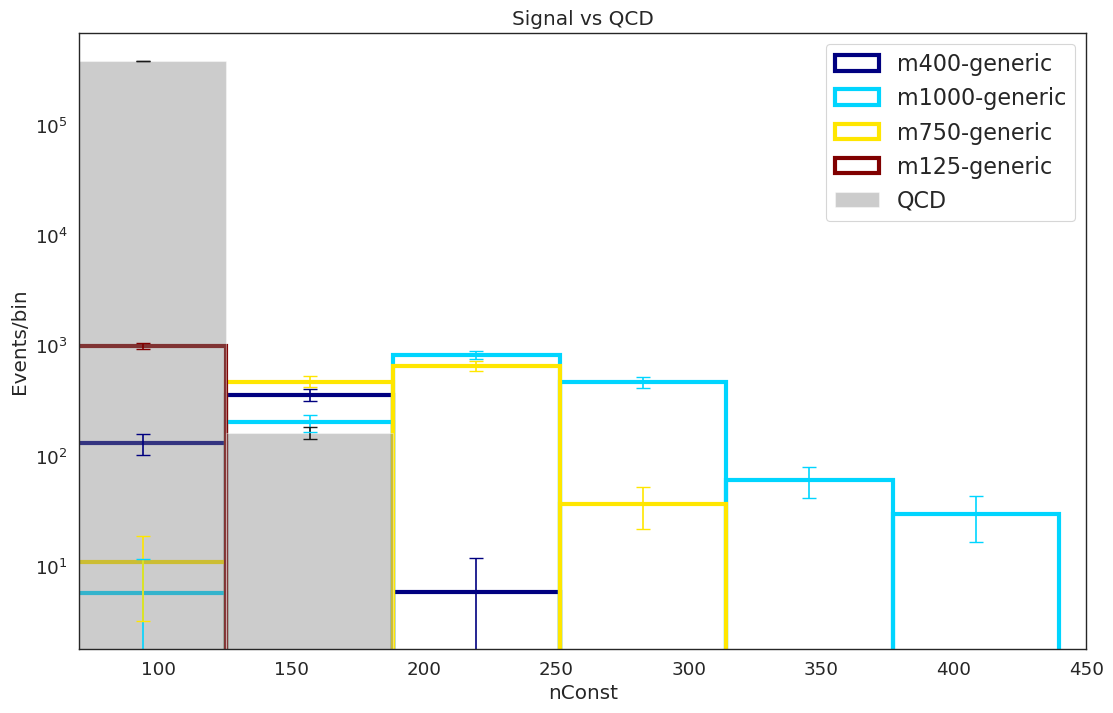

In [134]:
#PART 4
#Make a combined signal vs QCD plot for the signals of all datafiles

import matplotlib.pylab as pl #just for the 'jet' color map

datafiles_reduced = {name: f for name, f in datafiles.items() if name[-7:]=='generic' and ('md' not in name)} #Specify which files you want to keep


plt.figure(figsize=(13,8))

colors = pl.cm.jet(np.linspace(0,1,len(datafiles_reduced)))

for n, (name, f) in enumerate(datafiles_reduced.items()):
    sig = f["Signal"].to_boost() 
    plt.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5, fill=False, label = name,linewidth=3, edgecolor= colors[n],ecolor =colors[n],capsize =5)

    
exp=datafiles['m125-darkPhoHad']['expected'].to_boost() #Assuming the QCD background is identical for every bin
plt.bar(*exp.axes.centers, exp.values(), width=exp.axes.widths[0], yerr=exp.variances()**0.5,color= 'grey', alpha = 0.4,label='QCD',capsize =5)
plt.title("Signal vs QCD")
plt.xlabel("nConst")
plt.ylabel("Events/bin")
plt.yscale('log')
#plt.ylim(10**-2,10**8)
plt.xlim(70,450)
plt.legend(fontsize=16)
# plt.savefig('/plots/Combined_Signal_vs_QCD.png')
# plt.savefig('/plots/Combined_Signal_vs_QCD.pdf')
plt.show()